#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_data = pd.read_csv(path + 'data01_train.csv')
test_data = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요.
train_data.drop('subject', axis=1, inplace=True)
test_data.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
print("train 데이터 크기 (행, 열):", train_data.shape)
print("test 데이터 크기 (행, 열):", test_data.shape)
print("features 데이터 크기 (행, 열):", features.shape)

train 데이터 크기 (행, 열): (5881, 562)
test 데이터 크기 (행, 열): (1471, 562)
features 데이터 크기 (행, 열): (561, 4)


In [ ]:
#전체 데이터의 상위 5개 행 확인
print("train 데이터 :")
display(train_data.head(5))

print("\ntest 데이터 :")
display(test_data.head(5))

print("\nfeatures 데이터 :")
display(features.head(5))

train 데이터 :


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS



test 데이터 :


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING



features 데이터 :


,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
print("train 데이터 (수치형):")
display(train_data.describe())

print("\ntest 데이터 (수치형):")
display(test_data.describe())

print("\nfeatures 데이터 (수치형):")
display(features.describe())

train 데이터 (수치형):


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000



test 데이터 (수치형):


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766



features 데이터 (수치형):


,sensor,agg,axis,feature_name
count,561,561,436,561
unique,18,27,62,561
top,fBodyGyro,bandsEnergy(),X,"angle(Z,gravityMean)"
freq,79,126,76,1


In [ ]:
#전체 데이터의 모든 변수 확인

# train 데이터의 정보 확인
print("train_df 정보:")
train_data.info()

# test 데이터의 정보 확인
print("\ntest_df 정보:")
test_data.info()

# Feature 데이터 정보 확인
print("\nFeature 데이터 정보:")
features.info()

train_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB

test_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB

Feature 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sensor        561 non-null    object
 1   agg           561 non-null    object
 2   axis          436 non-null    object
 3   feature_name  561 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
# 데이터 분할을 합니다.
x = train_data.drop(columns=['Activity'])
y = train_data['Activity']

### (2) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(
      x,
      y,
      test_size=0.2,
      random_state=4420,
      stratify=y # 비율 유지
    )

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
print(x_train.shape, x_val.shape)

(4704, 561) (1177, 561)


### (4) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
# 정수 인코딩 변환(LabelEncoder)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
print(y_train)
print(y_val)

[5 1 2 ... 2 0 0]
[2 3 3 ... 2 5 0]


In [ ]:
# 기존 레이블 저장

# 정수 인코딩된 레이블을 DataFrame으로 저장
encoded_df = pd.DataFrame(y_train, columns=['encoded_label'])

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [ ]:
# 모델 설계

# 입력 데이터의 특성 수 확인
input_dim = x_train.shape[1]
num_classes = len(np.unique(y_train))

# 모델1: Hidden Layer 없이 Output만 있는 구조
def build_model1():
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(num_classes, activation='softmax')  # 출력층만
    ])
    return model

model1 = build_model1()
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │         3,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습

# 컴파일
model1.compile(
    optimizer=Adam(learning_rate=0.005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 학습
history1 = model1.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6215 - loss: 0.9922 - val_accuracy: 0.8811 - val_loss: 0.4554
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9031 - loss: 0.3924 - val_accuracy: 0.9006 - val_loss: 0.3331
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9223 - loss: 0.2882 - val_accuracy: 0.9014 - val_loss: 0.3111
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9416 - loss: 0.2285 - val_accuracy: 0.9142 - val_loss: 0.2618
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9470 - loss: 0.2003 - val_accuracy: 0.9303 - val_loss: 0.2184
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9493 - loss: 0.1788 - val_accuracy: 0.9235 - val_loss: 0.2093
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9523 - loss: 0.1641 - val_accuracy: 0.9363 - val_loss: 0.2010
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9615 - loss: 0.1434 - val_accuracy: 0.9388 - val_loss

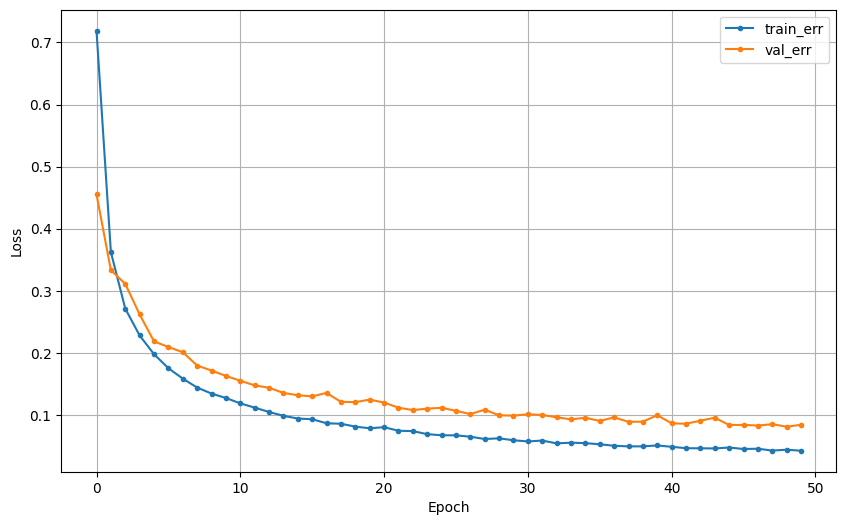

In [ ]:
# 학습곡선
dl_history_plot(history1.history)

In [ ]:
# 예측 및 평가
val_loss, val_acc = model1.evaluate(x_val, y_val, verbose=0)
print(f"모델1 정확도(Validation): {val_acc:.4f}")

모델1 정확도(Validation): 0.9626


In [ ]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!
acc_list = []

for i in range(5):
    clear_session()
    model = build_model1()
    model.compile(optimizer=Adam(learning_rate=0.005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=30, batch_size=64, verbose=0)
    _, acc = model.evaluate(x_val, y_val, verbose=0)
    acc_list.append(acc)
    print(f"{i}회 검증 정확도: {acc:.4f}")


avg_acc = np.mean(acc_list)
print(f"\n모델1 평균 정확도 (5회): {avg_acc:.4f}")

0회 검증 정확도: 0.9592
1회 검증 정확도: 0.9609
2회 검증 정확도: 0.9592
3회 검증 정확도: 0.9550
4회 검증 정확도: 0.9584

모델1 평균 정확도 (5회): 0.9585


### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [ ]:
# 모델 설계
def build_model2():
    model = Sequential([
        Input(shape=(input_dim,)),               # 입력층
        Dense(256, activation='relu'),           # 은닉층 1
        Dense(128, activation='relu'),            # 은닉층 2
        Dense(128, activation='relu'),            # 은닉층 3
        Dense(64, activation='relu'),            # 은닉층 4
        Dense(64, activation='relu'),            # 은닉층 5
        Dense(num_classes, activation='softmax') # 출력층
    ])
    return model

model2 = build_model2()
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,086 (805.02 KB)

 Trainable params: 206,086 (805.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습

# 컴파일
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 학습
history2 = model2.fit(
    x_train, y_train,
    validation_data=(x_val, y_val), # 검증 데이터
    epochs=30,
    batch_size=64,
    verbose=1
)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5158 - loss: 1.0540 - val_accuracy: 0.7910 - val_loss: 0.3982
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8483 - loss: 0.3251 - val_accuracy: 0.9125 - val_loss: 0.2487
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9186 - loss: 0.2044 - val_accuracy: 0.9218 - val_loss: 0.1933
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9293 - loss: 0.1813 - val_accuracy: 0.9099 - val_loss: 0.2428
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9461 - loss: 0.1318 - val_accuracy: 0.9201 - val_loss: 0.1915
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9519 - loss: 0.1236 - val_accuracy: 0.9414 - val_loss: 0.1705
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9635 - loss: 0.0917 - val_accuracy: 0.9431 - val_loss: 0.1501
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9602 - loss: 0.1017 - val_accuracy: 0.9422 - val_lo

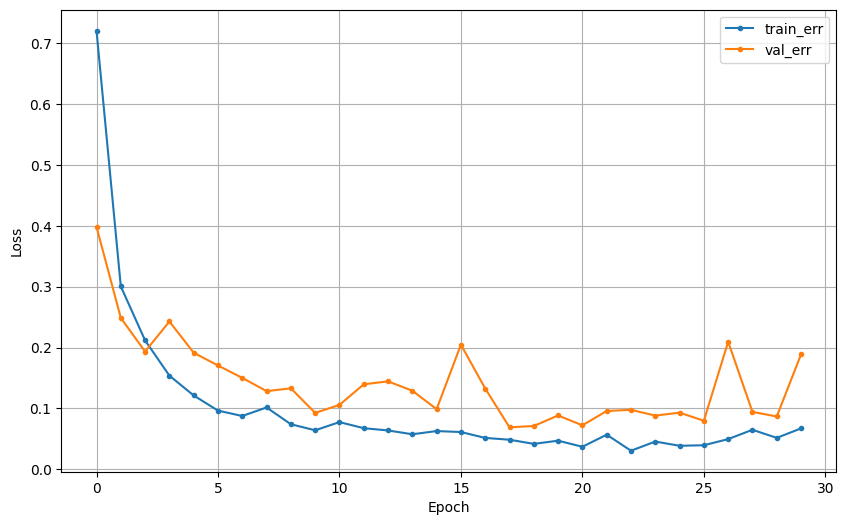

In [ ]:
# 학습곡선
dl_history_plot(history2.history)

In [ ]:
# 예측 및 평가
val_loss2, val_acc2 = model2.evaluate(x_val, y_val, verbose=0)
print(f"모델2 정확도(Validation): {val_acc2:.4f}")

모델2 정확도(Validation): 0.9371


### (3) 모델3 : 학습률, epoch 등 조정

In [ ]:
# 모델 설계
def build_model3():
    model = Sequential([
        Input(shape=(input_dim,)),               # 입력층
        Dense(256, activation='relu'),
        Dropout(0.3), # 과적합 방지
        Dense(128, activation='relu'),
        Dropout(0.3), # 과적합 방지
        Dense(128, activation='relu'),
        Dropout(0.2), # 과적합 방지
        Dense(64, activation='relu'),
        Dropout(0.2), # 과적합 방지
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax') # 출력층
    ])
    return model

model3 = build_model3()
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,086 (805.02 KB)

 Trainable params: 206,086 (805.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model3.compile(
    optimizer=Adam(learning_rate=0.0005),  # 학습률 조정
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history3 = model3.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,  # 에폭 증가
    batch_size=64,
    verbose=1
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3191 - loss: 1.5302 - val_accuracy: 0.6253 - val_loss: 0.9223
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5829 - loss: 0.8902 - val_accuracy: 0.7468 - val_loss: 0.5381
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7371 - loss: 0.5701 - val_accuracy: 0.8547 - val_loss: 0.3906
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8286 - loss: 0.3858 - val_accuracy: 0.8836 - val_loss: 0.2729
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8665 - loss: 0.3213 - val_accuracy: 0.8955 - val_loss: 0.2430
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8882 - loss: 0.2735 - val_accuracy: 0.9074 - val_loss: 0.2248
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9089 - loss: 0.2280 - val_accuracy: 0.9235 - val_loss: 0.1786
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9321 - loss: 0.1812 - val_accuracy: 0.9261 - val_l

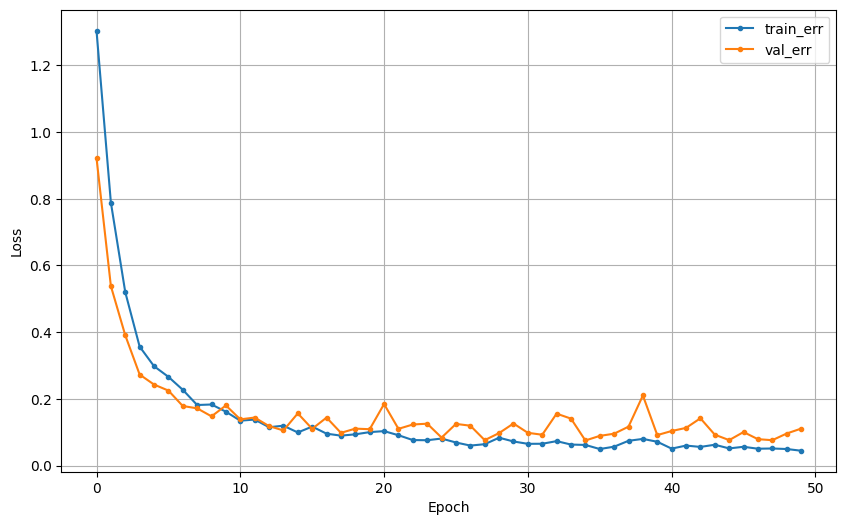

In [ ]:
# 학습곡선
dl_history_plot(history3.history)

In [ ]:
# 예측 및 평가
val_loss3, val_acc3 = model3.evaluate(x_val, y_val, verbose=0)
print(f"모델3 정확도(Validation): {val_acc3:.4f}")

모델3 정확도(Validation): 0.9635


### (4) 모델4 :  학습률, epoch 등 조정

In [ ]:
# 모델 설계
from keras.layers import BatchNormalization

def build_model4():
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])
    return model

model4 = build_model4()
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 128)            │        71,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,398 (341.40 KB)

 Trainable params: 87,014 (339.90 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# 컴파일 및 학습
model4.compile(
    optimizer=Adam(learning_rate=0.0003),  # 더 낮은 학습률로 안정적 학습
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history4 = model4.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2716 - loss: 1.8774 - val_accuracy: 0.6551 - val_loss: 1.5968
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5235 - loss: 1.1734 - val_accuracy: 0.7128 - val_loss: 1.1407
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6824 - loss: 0.8235 - val_accuracy: 0.8352 - val_loss: 0.6638
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7639 - loss: 0.6237 - val_accuracy: 0.8607 - val_loss: 0.4320
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8179 - loss: 0.4773 - val_accuracy: 0.8700 - val_loss: 0.3290
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8471 - loss: 0.3982 - val_accuracy: 0.9074 - val_loss: 0.2392
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8768 - loss: 0.3166 - val_accuracy: 0.9320 - val_loss: 0.1745
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8977 - loss: 0.2885 - val_accuracy: 0.9371 - val_loss

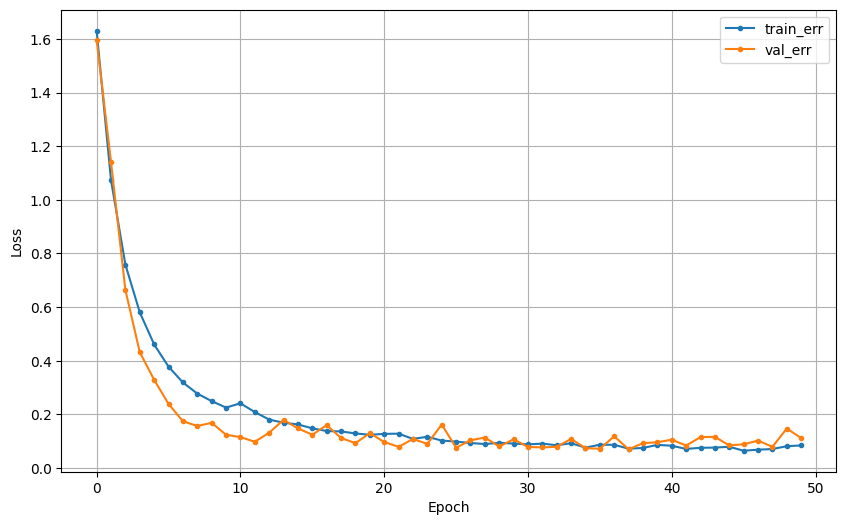

In [ ]:
# 학습곡선
dl_history_plot(history4.history)

In [ ]:
# 예측 및 평가
val_loss4, val_acc4 = model4.evaluate(x_val, y_val, verbose=0)
print(f"모델4 정확도(Validation): {val_acc4:.4f}")

모델4 정확도(Validation): 0.9669


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
#전체 데이터 불러오기(test)
test_df = pd.read_csv(path + '/data01_test.csv')
# subject 삭제
test_df = test_df.drop(columns=['subject'])
# x, y 분할
X_test = test_df.drop(columns=['Activity'])
y_test = test_df['Activity']
# x : 스케일링 적용
X_test_scaled = scaler.transform(X_test)
# y : 정수인코딩 적용
y_test_encoded = le.transform(y_test)

In [ ]:
# test 데이터에 대한 성능 측정
def evaluate_model_on_test(model, name="Model"):
    loss, acc = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
    print(f"{name} Test Accuracy: {acc:.4f}")
    return acc

acc_test1 = evaluate_model_on_test(model1, "모델1")
acc_test2 = evaluate_model_on_test(model2, "모델2")
acc_test3 = evaluate_model_on_test(model3, "모델3")
acc_test4 = evaluate_model_on_test(model4, "모델4")

results_df = pd.DataFrame({
    '모델': ['모델1', '모델2', '모델3', '모델4'],
    'Test Accuracy': [acc_test1, acc_test2, acc_test3, acc_test4]
})

print("\n최종 성능 비교:")
display(results_df.sort_values(by='Test Accuracy', ascending=False))

모델1 Test Accuracy: 0.9762
모델2 Test Accuracy: 0.9524
모델3 Test Accuracy: 0.9769
모델4 Test Accuracy: 0.9721

최종 성능 비교:


,모델,Test Accuracy
2,모델3,0.976886
0,모델1,0.976207
3,모델4,0.972128
1,모델2,0.952413


#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.